### https://learn.microsoft.com/ja-jp/training/paths/pytorch-fundamentals/

#### Datasets and Dataloaders
データセットのコードはモデル学習のコードから切り離すことが理想
PyTorch は `torch.utils.data.DataLoader` と `torch.utils.data.Dataset` という2つのデータプリミティブを提供し、
ロード済みのデータセットや独自のデータを使用することができます。Datasetはサンプルとそれに対応するラベルを格納し、
DataLoaderはサンプルに簡単にアクセスできるようにDatasetの周りにイテラブルをラップしています。

In [2]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt
import numpy as np

PyTorchドメインライブラリは、`torch.utils.data.Dataset` をサブクラスとして、特定のデータに固有の関数を実装したサンプルプリロードデータセット（FashionMNISTなど）を多数提供しています。これらのデータセットは、プロトタイピングやモデルのベンチマークを行うためのサンプルとして使うことができる

We load the FashionMNIST Dataset with the following parameters:
 - **root** is the path where the train/test data is stored,
 - **train** specifies training or test dataset,
 - **download=True** downloads the data from the Internet if it's not available at `root`.
 - **transform** and `target_transform` specify the feature and label transformations

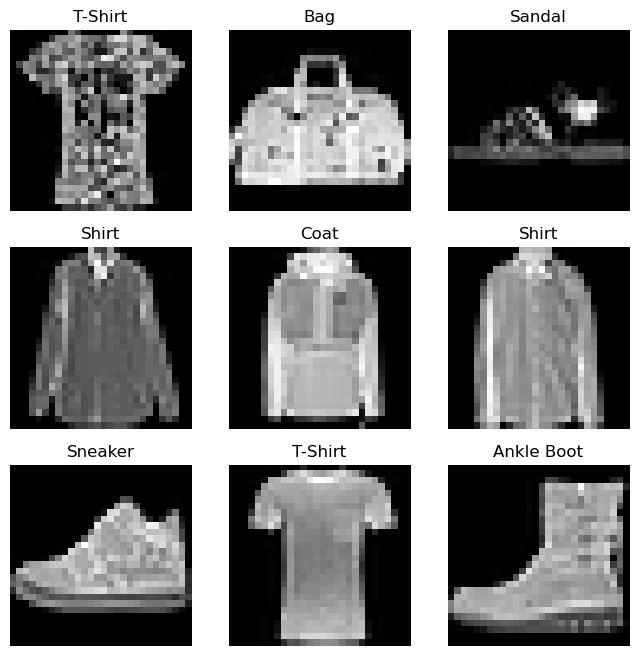

In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

#### Preparing your data for training with DataLoaders
機械学習では、データセットに含まれる特徴とラベルが何であるかを指定する必要があります。特徴は入力で、ラベルは出力です。特徴量を使い、ラベルを予測するモデルを学習させます。
ラベルとは、10種類のクラスタイプのことです： Tシャツ、サンダル、ドレスなど
特徴量とは、画像のピクセルに含まれるパターン
DataLoaderは、この複雑さを抽象化し、簡単なAPIにしてくれる反復可能なものです。Dataloaderを使用するには、以下のパラメータを設定する必要があります：
- data モデル学習に使用する学習データ、モデルの評価に使用するテストデータ
- batch_size=64 各バッチで処理されるレコードの数
- shuffle インデックスによるデータのランダム化サンプル

The ``DataLoader`` is an iterable that abstracts this complexity for us in an easy API.  We use the Dataloader, we need to set the following paraments:
 - **data** the training data that will be used to train the model; and test data to evaluate the model
 - **batch size** the number of records to be processed in each batch
 - **shuffle** the randoms sample of the data by indices


In [4]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

#### Iterate through the DataLoader
データセットをDataloaderにロードし、必要に応じてデータセットを反復処理することができるようになりました。以下の各繰り返しは、train_featuresとtrain_labels（それぞれbatch_size=64の特徴量とラベルを含む）のバッチを返します。shuffle=Trueを指定したため，すべてのバッチを反復処理した後，データはシャッフルされます（データのロード順序をより細かく制御するためです）．

In [ ]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

#### Normalization
正規化とは、一般的なデータの前処理技術で、データをスケールしたり変換したりして、各特徴からの学習貢献度が等しくなるようにするために適用されます。例えば、グレースケール画像の各ピクセルには0から255までの値があり、これが特徴量となります。あるピクセルの値が17で、別のピクセルの値が197だとします。画素のボリュームが大きい方が学習を逸脱するため、画素の重要度が偏在することになります。正規化とは、データの範囲を変更することで、特徴量間の区別を歪めることなく、データの範囲を変更することです。この前処理は、次のようなことを避けるために行われます：

- 予測精度の低下
- モデルの学習が困難になる
- 特徴量データの範囲が不利な分布になる


#### Transforms
機械学習アルゴリズムの学習に必要なデータは、必ずしも最終的に加工された状態で提供されるわけではありません。そこで、データに何らかの加工を施し、学習に適した形にするためにトランスフォームを使用します。

すべてのTorchVisionデータセットには2つのパラメータ（特徴を修正する`transform`とラベルを修正する`target_transform`）があり、変換ロジックを含むcallableを受け付けます。`torchvision.transforms`モジュールは、一般的に使用されるいくつかの変換をすぐに提供します。

FashionMNISTの特徴量はPIL Image形式であり、ラベルは整数です。学習には、特徴量は正規化されたテンソルとして、ラベルはワンホットエンコードされたテンソルとして必要です。これらの変換を行うために、ToTensorとLambdaを使用します。

In [ ]:
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda

ds = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
)

#### ToTensor()
ToTensorは、PIL画像またはNumPyのndarrayをFloatTensorに変換し、画像のピクセル強度値を[0., 1]の範囲にスケーリングする。

#### Lambda transforms
ラムダ変換は、ユーザが定義した任意のラムダ関数を適用します。ここでは、整数をワンホットエンコードされたテンソルに変換する関数を定義しています。まず、サイズ10（データセットのラベル数）のゼロテンソルを作成し、ラベルyで指定されたインデックスに値=1を割り当てるscatterを呼び出します。この処理を行う別のオプションとして、`torch.nn.functional.one_hot`を使用することもできます。

In [ ]:
target_transform = Lambda(lambda y: torch.zeros(
    10, dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))